In [22]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [23]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [24]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 200000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [25]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [26]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [27]:
# Create TF Model.
class Generator(Model):
    # Set layers.
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(7 * 7 * 128)
        self.bn1 = layers.BatchNormalization()
        self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = self.conv2tr1(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
class Discriminator(Model):
    # Set layers.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024)
        self.bn3 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        return self.fc2(x)

# Build neural network model.
generator = Generator()
discriminator = Discriminator()

In [28]:
# Losses.
def generator_loss(reconstructed_image):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=reconstructed_image, labels=tf.ones([batch_size], dtype=tf.int32)))
    return gen_loss

def discriminator_loss(disc_fake, disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
    return disc_loss_real + disc_loss_fake

# Optimizers.
optimizer_gen = tf.optimizers.Adam(learning_rate=lr_generator)#, beta_1=0.5, beta_2=0.999)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)#, beta_1=0.5, beta_2=0.999)

In [29]:
# Optimization process. Inputs: real image and noise.
def run_optimization(real_images):
    
    # Rescale to [-1, 1], the input range of the discriminator
    real_images = real_images * 2. - 1.

    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)
        disc_real = discriminator(real_images, is_training=True)

        disc_loss = discriminator_loss(disc_fake, disc_real)
            
    # Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss,  discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,  discriminator.trainable_variables))
    
    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)

        gen_loss = generator_loss(disc_fake)
            
    gradients_gen = g.gradient(gen_loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [30]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    if step == 0:
        # Generate noise.
        noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
        gen_loss = generator_loss(discriminator(generator(noise)))
        disc_loss = discriminator_loss(discriminator(batch_x), discriminator(generator(noise)))
        print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
        continue
    
    # Run the optimization.
    gen_loss, disc_loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen_loss: 0.692318, disc_loss: 1.393931
step: 500, gen_loss: 1.861718, disc_loss: 0.443147
step: 1000, gen_loss: 2.128000, disc_loss: 0.409986
step: 1500, gen_loss: 2.261119, disc_loss: 0.491149
step: 2000, gen_loss: 2.491185, disc_loss: 0.390419
step: 2500, gen_loss: 3.057126, disc_loss: 0.371908
step: 3000, gen_loss: 2.813308, disc_loss: 0.502425
step: 3500, gen_loss: 3.100521, disc_loss: 0.269827
step: 4000, gen_loss: 3.402638, disc_loss: 0.121310
step: 4500, gen_loss: 3.599048, disc_loss: 0.247724
step: 5000, gen_loss: 3.433401, disc_loss: 0.219626
step: 5500, gen_loss: 2.855304, disc_loss: 0.180152
step: 6000, gen_loss: 4.335806, disc_loss: 0.125533
step: 6500, gen_loss: 4.048719, disc_loss: 0.145946
step: 7000, gen_loss: 4.170968, disc_loss: 0.074704
step: 7500, gen_loss: 5.252831, disc_loss: 0.117386
step: 8000, gen_loss: 4.645192, disc_loss: 0.195736
step: 8500, gen_loss: 3.987201, disc_loss: 0.089386
step: 9000, gen_loss: 5.064156, disc_loss: 0.149192
step: 9500, gen_

step: 77500, gen_loss: 6.391170, disc_loss: 0.101436
step: 78000, gen_loss: 10.260693, disc_loss: 0.044579
step: 78500, gen_loss: 9.812930, disc_loss: 0.173024
step: 79000, gen_loss: 9.960424, disc_loss: 0.002909
step: 79500, gen_loss: 10.738214, disc_loss: 0.004024
step: 80000, gen_loss: 9.443613, disc_loss: 0.016554
step: 80500, gen_loss: 9.718397, disc_loss: 0.009377
step: 81000, gen_loss: 7.401966, disc_loss: 0.113898
step: 81500, gen_loss: 9.239663, disc_loss: 0.080312
step: 82000, gen_loss: 9.436039, disc_loss: 0.016280
step: 82500, gen_loss: 9.161411, disc_loss: 0.011178
step: 83000, gen_loss: 10.112592, disc_loss: 0.005731
step: 83500, gen_loss: 7.854105, disc_loss: 0.024447
step: 84000, gen_loss: 7.962905, disc_loss: 0.016950
step: 84500, gen_loss: 9.163364, disc_loss: 0.002964
step: 85000, gen_loss: 7.031075, disc_loss: 0.001475
step: 85500, gen_loss: 10.883480, disc_loss: 0.012948
step: 86000, gen_loss: 10.352211, disc_loss: 0.012967
step: 86500, gen_loss: 10.844675, disc_lo

step: 153500, gen_loss: 9.064872, disc_loss: 0.003031
step: 154000, gen_loss: 13.040009, disc_loss: 0.004769
step: 154500, gen_loss: 11.296190, disc_loss: 0.002782
step: 155000, gen_loss: 12.188057, disc_loss: 0.024239
step: 155500, gen_loss: 10.945911, disc_loss: 0.001429
step: 156000, gen_loss: 10.828922, disc_loss: 0.001690
step: 156500, gen_loss: 8.620146, disc_loss: 0.004798
step: 157000, gen_loss: 13.121694, disc_loss: 0.006579
step: 157500, gen_loss: 14.316735, disc_loss: 0.005448
step: 158000, gen_loss: 9.124212, disc_loss: 0.029859
step: 158500, gen_loss: 12.105214, disc_loss: 0.002637
step: 159000, gen_loss: 9.565455, disc_loss: 0.002056
step: 159500, gen_loss: 12.059174, disc_loss: 0.003618
step: 160000, gen_loss: 12.441402, disc_loss: 0.030883
step: 160500, gen_loss: 8.033268, disc_loss: 0.039743
step: 161000, gen_loss: 10.883586, disc_loss: 0.000875
step: 161500, gen_loss: 11.464121, disc_loss: 0.005234
step: 162000, gen_loss: 13.273256, disc_loss: 0.001563
step: 162500, g

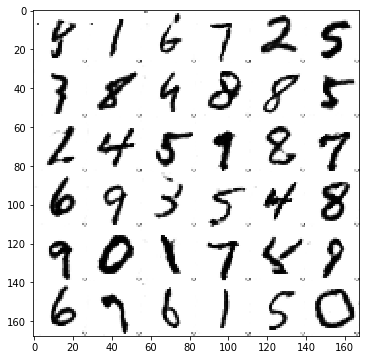

In [32]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.normal(-1., 1., size=[n, noise_dim]).astype(np.float32)
    # Generate image from noise.
    g = generator(z).numpy()
    # Rescale to original [0, 1]
    g = (g + 1.) / 2
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()